## Github URL

---

https://github.com/Arravee/ExoPlanet_Hunting

## Dataset Description

In this report, we will be looking at a dataset covering over 6000 stars. The dataset records readings of flux for each star 3197 times. By looking at the recordings we hope to label if a star has an exoplanet or not, "2" and "1" respectively. We are essentially trying to create a NN that can utilize the exoplanet transit method, i.e. when an exoplanet transits across a star we expect to see a dip in flux. For a more in-depth explanation please see: https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/. This data is directly sourced from the Miluski Archive, an archive of data from the K2 mission, a NASA mission that is added onto the work of the Kepler mission. This type of program is extremely useful in helping astronomers comb through thousands if not millions of data points, especially now that JWST is also in orbit.



In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import multiprocessing

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, concatenate
from keras.layers import Conv1D, MaxPool1D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant

from keras.models import Sequential, Model,load_model

from sklearn.model_selection import train_test_split


## EDA

In [ ]:
#Import the Dataset and get a general initial look at it, change path according to your system. I am creating this notebook in Colab so I will be pulling from Google Drive.
train_df = pd.read_csv('/content/drive/MyDrive/exoTrain.csv')
print(train_df.shape)
train_df.head()

(5087, 3198)


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
#Now let's look at value counts. This is important because we have worked with heavily skewed data berfore and
#if there a low amount of positive/negative samples we will need to adjust the ratio before plugging the data into 
#our future models.

train_df['LABEL'].value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

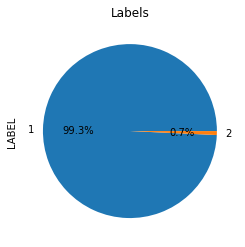

In [ ]:
train_df['LABEL'].value_counts().plot(kind='pie',grid=True,title='Labels', autopct='%1.1f%%')

The proportion of positive to negative cases is extremely skewed. However, this is somewhat expected with this type of dataset. It is very difficult to detect small exoplanets with the transit method and as noted in a 2008 paper by Cumming, Butler, et. al., "The Keck Planet Search: Detectability and the Minimum Mass and Orbital Period Distribution of Extrasolar Planets", only 3-4% of Sun-like stars have a "giant" planet.

To adjust to this skewed dataset we will use a technique called augmentation. This allows us to repeatedly use the positive samples to get a relatively equal distribution in each batch. Essentially we are rotating stars in and out of our batches to keep a balanced proportion.

Our first step is to split our labels from the flux and put them into an array for our model to read.

In [ ]:
y = train_df['LABEL'].to_numpy()
y_new = np.array([[i - 1] for i in y])
y_new[:20]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
X = train_df.loc[:, train_df.columns.drop('LABEL')].to_numpy()
X

array([[ 93.85,  83.81,  20.1 , ...,  61.42,   5.08, -39.54],
       [-38.88, -33.83, -58.54, ...,   6.46,  16.  ,  19.93],
       [532.64, 535.92, 513.73, ..., -28.91, -70.02, -96.67],
       ...,
       [273.39, 278.  , 261.73, ...,  88.42,  79.07,  79.43],
       [  3.82,   2.09,  -3.29, ..., -14.55,  -6.41,  -2.55],
       [323.28, 306.36, 293.16, ..., -16.72, -14.09,  27.82]])

In [ ]:
X.shape

(5087, 3197)

Our next step is to split our data into a training and validation set for our model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y_new, test_size=0.3, random_state=42)

In [ ]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Finally before moving onto creating our augmentation we will normalize the data.

In [ ]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)

In [ ]:
len(x_train)

3560

In [ ]:
len(x_test)

1527

In [ ]:
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

In [ ]:
x_train.shape[1:]

(3197, 2)

In [ ]:
x_test.shape[1:]

(3197, 2)

In [ ]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

## Model Architecture


Unlike the cancer research, we did previously we will use a 1D convolution network. As we will be working with flux points and not image data each layer will also be noticeably less dense. We will use the initial model from our cancer research as a "jump-off" point and modify the hyperparameters as we see fit going forward. 

In [ ]:
model_1 = Sequential()
model_1.add(Conv1D(8, kernel_size=11, activation = 'relu', input_shape=x_train.shape[1:]))
model_1.add(Conv1D(8, kernel_size=11, activation = 'relu'))
model_1.add(MaxPool1D(strides=4))
model_1.add(BatchNormalization())

model_1.add(Conv1D(16, kernel_size=11, activation = 'relu'))
model_1.add(Conv1D(16, kernel_size=11, activation = 'relu'))
model_1.add(MaxPool1D(strides=4))
model_1.add(BatchNormalization())

model_1.add(Conv1D(32, kernel_size=11, activation = 'relu'))
model_1.add(Conv1D(32, kernel_size=11, activation = 'relu'))
model_1.add(MaxPool1D(strides=4))
model_1.add(BatchNormalization())

model_1.add(Flatten())
model_1.add(Dense(64, activation = "relu"))
model_1.add(Dropout(0.25))
model_1.add(Dense(1, activation = 'relu'))

model_1.add(Dense(64, activation = "relu"))
model_1.add(Dropout(0.25))
model_1.add(Dense(1, activation = 'relu'))

model_1.add(Dropout(0.25))
model_1.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 3187, 8)           184       
                                                                 
 conv1d_21 (Conv1D)          (None, 3177, 8)           712       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 794, 8)           0         
 1D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 794, 8)           32        
 hNormalization)                                                 
                                                                 
 conv1d_22 (Conv1D)          (None, 784, 16)           1424      
                                                                 
 conv1d_23 (Conv1D)          (None, 774, 16)          

In [ ]:
CNN_1 = model_1.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=30,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/30
99/99 - 1s - loss: 0.3040 - accuracy: 0.8804 - val_loss: 0.2678 - val_accuracy: 0.9921 - 956ms/epoch - 10ms/step
Epoch 2/30
99/99 - 1s - loss: 0.3389 - accuracy: 0.8602 - val_loss: 0.2546 - val_accuracy: 0.9921 - 897ms/epoch - 9ms/step
Epoch 3/30
99/99 - 1s - loss: 0.3333 - accuracy: 0.8636 - val_loss: 0.2680 - val_accuracy: 0.9921 - 897ms/epoch - 9ms/step
Epoch 4/30
99/99 - 1s - loss: 0.3094 - accuracy: 0.8772 - val_loss: 0.2649 - val_accuracy: 0.9921 - 905ms/epoch - 9ms/step
Epoch 5/30
99/99 - 1s - loss: 0.3144 - accuracy: 0.8741 - val_loss: 0.2632 - val_accuracy: 0.9921 - 891ms/epoch - 9ms/step
Epoch 6/30
99/99 - 1s - loss: 0.3216 - accuracy: 0.8747 - val_loss: 0.2663 - val_accuracy: 0.9908 - 884ms/epoch - 9ms/step
Epoch 7/30
99/99 - 1s - loss: 0.3244 - accuracy: 0.8684 - val_loss: 0.2537 - val_accuracy: 0.9935 - 879ms/epoch - 9ms/step
Epoch 8/30
99/99 - 1s - loss: 0.2982 - accuracy: 0.8842 - val_loss: 0.2515 - val_accuracy: 0.9935 - 867ms/epoch - 9ms/step
Epoch 9/30
99/9

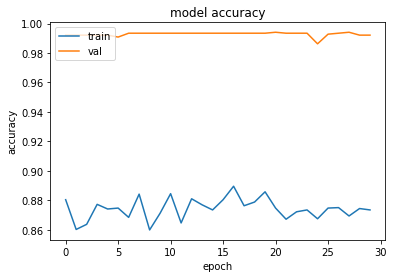

In [ ]:
plt.plot(CNN_1.history['accuracy'])
plt.plot(CNN_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_2 = Sequential()
model_2.add(Conv1D(8, kernel_size=11, activation = 'relu', input_shape=x_train.shape[1:]))
model_2.add(MaxPool1D(strides=4))
model_2.add(BatchNormalization())

model_2.add(Conv1D(16, kernel_size=11, activation = 'relu'))
model_2.add(MaxPool1D(strides=4))
model_2.add(BatchNormalization())

model_2.add(Conv1D(32, kernel_size=11, activation = 'relu'))
model_2.add(MaxPool1D(strides=4))
model_2.add(BatchNormalization())

model_2.add(Conv1D(64, kernel_size=11, activation = 'relu'))
model_2.add(MaxPool1D(strides=4))
model_2.add(BatchNormalization())

model_2.add(Flatten())
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation = 'relu'))

model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.25))
model_2.add(Dense(1, activation = 'relu'))

model_2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.0005)
model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_106 (Conv1D)         (None, 3187, 8)           184       
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 797, 8)           0         
 g1D)                                                            
                                                                 
 batch_normalization_52 (Bat  (None, 797, 8)           32        
 chNormalization)                                                
                                                                 
 conv1d_107 (Conv1D)         (None, 787, 16)           1424      
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 197, 16)          0         
 g1D)                                                            
                                                     

In [ ]:
CNN_2 = model_2.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=30,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/30
99/99 - 3s - loss: 0.6541 - accuracy: 0.6386 - val_loss: 0.6971 - val_accuracy: 0.1932 - 3s/epoch - 29ms/step
Epoch 2/30
99/99 - 1s - loss: 0.4964 - accuracy: 0.8469 - val_loss: 0.4549 - val_accuracy: 0.6542 - 807ms/epoch - 8ms/step
Epoch 3/30
99/99 - 1s - loss: 0.3730 - accuracy: 0.9309 - val_loss: 0.1416 - val_accuracy: 0.8847 - 812ms/epoch - 8ms/step
Epoch 4/30
99/99 - 1s - loss: 0.3576 - accuracy: 0.9343 - val_loss: 0.1473 - val_accuracy: 0.8756 - 810ms/epoch - 8ms/step
Epoch 5/30
99/99 - 1s - loss: 0.3272 - accuracy: 0.9504 - val_loss: 0.1358 - val_accuracy: 0.8985 - 810ms/epoch - 8ms/step
Epoch 6/30
99/99 - 1s - loss: 0.3011 - accuracy: 0.9697 - val_loss: 0.1107 - val_accuracy: 0.9162 - 814ms/epoch - 8ms/step
Epoch 7/30
99/99 - 1s - loss: 0.3060 - accuracy: 0.9508 - val_loss: 0.1113 - val_accuracy: 0.9214 - 806ms/epoch - 8ms/step
Epoch 8/30
99/99 - 1s - loss: 0.2793 - accuracy: 0.9691 - val_loss: 0.0722 - val_accuracy: 0.9646 - 799ms/epoch - 8ms/step
Epoch 9/30
99/99 -

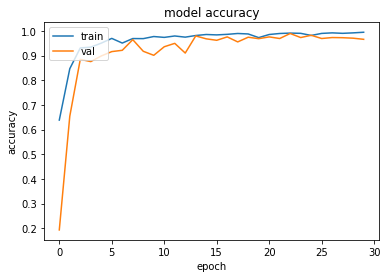

In [ ]:
plt.plot(CNN_2.history['accuracy'])
plt.plot(CNN_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_3 = Sequential()
model_3.add(Conv1D(8, kernel_size=11, activation = 'relu', input_shape=x_train.shape[1:]))
model_3.add(MaxPool1D(strides=4))
model_3.add(BatchNormalization())

model_3.add(Conv1D(16, kernel_size=11, activation = 'relu'))
model_3.add(MaxPool1D(strides=4))
model_3.add(BatchNormalization())

model_3.add(Conv1D(32, kernel_size=11, activation = 'relu'))
model_3.add(MaxPool1D(strides=4))
model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(64, activation = "relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation = 'relu'))

model_3.add(Dense(64, activation = "relu"))
model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation = 'relu'))

model_3.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model_3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_110 (Conv1D)         (None, 3187, 8)           184       
                                                                 
 max_pooling1d_56 (MaxPoolin  (None, 797, 8)           0         
 g1D)                                                            
                                                                 
 batch_normalization_56 (Bat  (None, 797, 8)           32        
 chNormalization)                                                
                                                                 
 conv1d_111 (Conv1D)         (None, 787, 16)           1424      
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 197, 16)          0         
 g1D)                                                            
                                                     

In [ ]:
CNN_3 = model_3.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=30,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/30
99/99 - 2s - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6943 - val_accuracy: 0.0079 - 2s/epoch - 20ms/step
Epoch 2/30
99/99 - 1s - loss: 0.6527 - accuracy: 0.6102 - val_loss: 0.7123 - val_accuracy: 0.3491 - 706ms/epoch - 7ms/step
Epoch 3/30
99/99 - 1s - loss: 0.5135 - accuracy: 0.7686 - val_loss: 0.5355 - val_accuracy: 0.6306 - 715ms/epoch - 7ms/step
Epoch 4/30
99/99 - 1s - loss: 0.4202 - accuracy: 0.8166 - val_loss: 0.7081 - val_accuracy: 0.5226 - 722ms/epoch - 7ms/step
Epoch 5/30
99/99 - 1s - loss: 0.3757 - accuracy: 0.8403 - val_loss: 0.3178 - val_accuracy: 0.8088 - 702ms/epoch - 7ms/step
Epoch 6/30
99/99 - 1s - loss: 0.2925 - accuracy: 0.8968 - val_loss: 0.4840 - val_accuracy: 0.7315 - 696ms/epoch - 7ms/step
Epoch 7/30
99/99 - 1s - loss: 0.2613 - accuracy: 0.9037 - val_loss: 0.5542 - val_accuracy: 0.7079 - 709ms/epoch - 7ms/step
Epoch 8/30
99/99 - 1s - loss: 0.2728 - accuracy: 0.9062 - val_loss: 0.3466 - val_accuracy: 0.8225 - 695ms/epoch - 7ms/step
Epoch 9/30
99/99 -

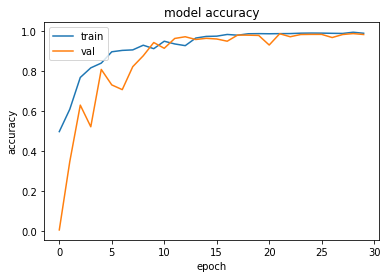

In [ ]:
plt.plot(CNN_3.history['accuracy'])
plt.plot(CNN_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results and Analysis

Our first model architecture was a 3 X 2 with the final activation layer being a sigmoid function due to its probabilistic properties. We never expected this to be the final model but instead a base to compare future architectures. This model was extremely consistent throughout the epochs. However, as we have seen in previous research problems this is not always a good thing. Due to the skewed nature of the data, a model not learning could mean it is simply labeling everything as "no-exoplanet" and unfortunately that is the case. You can see this by replacing the model used to predict in the y_hat assignment below. 

In our next model, we simplified the model as it seemed to be overfitting. We changed to a 4x1 structure and the Adam optimizer value. We immediately notice the new model climbing while also having a significantly lower loss. This is good. However, we can do better.

For the final attempt, we changed from the Adam optimizer to SGD. The big difference is while Adam is faster SGD tends to generalize better. Due to the significant speed of our model, the trade-off seems more than worth it. As we assumed our loss continues to do down while the model reaches high training and validation accuracy. 

Now we can use this model to look at our test data. 



In [ ]:
test_set = pd.read_csv('/content/drive/MyDrive/exoTest.csv')

In [ ]:
test_set_x = test_set.loc[:, test_set.columns.drop('LABEL')].to_numpy()

In [ ]:
test_set_x = ((test_set_x - np.mean(test_set_x, axis=1).reshape(-1,1)) / 
          np.std(test_set_x, axis=1).reshape(-1,1))
test_set_x = np.stack([test_set_x, uniform_filter1d(test_set_x, axis=1, size=200)], axis=2)

In [ ]:
y_hat = model_3.predict(test_set_x)[:,0]

In [ ]:
int_y = test_set['LABEL'].to_numpy()
test_set_y = np.array([[i - 1] for i in int_y])
test_set_y[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
non_idx = np.where(test_set_y[:,0] == 0.)[0]
yes_idx = np.where(test_set_y[:,0] == 1.)[0]

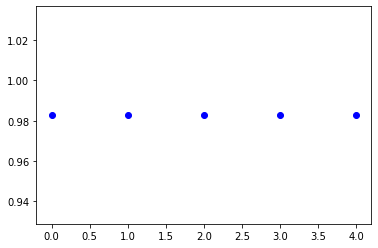

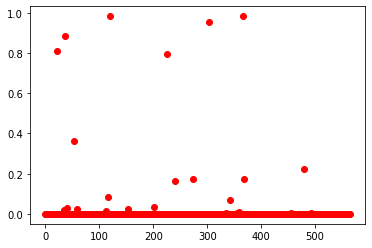

In [ ]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

## Conclusion 

Looking at our prediction values we can see that our cutoff is most likely around .97-.98. While there are a few points above this that are miscategorized, the purpose of this system, like many other ML systems, is as a tool to aid researchers combing through mountains of data. Based on our model researchers would have to review 6 points with a .98 cutoff out of 3000 stars. Each star with over 3000 observations. This is a big time save. 

For future iterations, we would like to continue to take a look at the SGD optimizer. It is currently at its default values, but adjusting such values could improve the model. We could also look at more variations of CNN such as ResNet or AlexNet. 

Overall, we accomplished what we set out to do and created a good base to carry out further research on this topic. 
